In [2]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", module="IPython")

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Root dir: F:\ID2223\Air_Quality_Prediction
Added the following directory to the PYTHONPATH: F:\ID2223\Air_Quality_Prediction
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Vienna Multi-Sensor Feature Backfill Pipeline</span>

## 🗒️ This notebook performs the following tasks:
1. Load Vienna sensor configuration from `vienna_sensors_config.json`
2. Read historical PM2.5 data from CSV files for **9 active sensors**
3. Fetch historical weather data for Vienna
4. Create/update Feature Groups in Hopsworks Feature Store  
5. Insert historical data for all Vienna sensors

## 📊 Sensors covered (9 active sensors):
- Kendlerstraße 40 (ID: 2850)
- Hausgrundweg 23 (ID: 2855)
- Allgemeines Krankenhaus Ostringweg (ID: 14537)
- Gaudenzdorfer Gürtel (ID: 2857)
- Belgradplatz (ID: 2870)
- Floridsdorf Gerichtsgasse (ID: 4738)
- Taborstraße (ID: 2860)
- Wehlistraße 366 (ID: 4736)
- Josef Redl Gasse 2 (ID: 4739)

## ✅ Prerequisites:
- All CSV files should be in `F:/ID2223/Air_Quality_Prediction/data/`
- AQICN_API_KEY and HOPSWORKS_API_KEY should be set in `~/.env`


### <span style='color:#ff5f27'> 📝 Imports

In [3]:
import datetime
import requests
import pandas as pd
import hopsworks
from mlfs.airquality import util
import datetime
from pathlib import Path
import json
import re
import os
import warnings
warnings.filterwarnings("ignore")

## <span style='color:#ff5f27'> 🗺️ STEP 1: Load Vienna Sensors Configuration</span>

This notebook uses a JSON configuration file that contains information about all Vienna air quality sensors.

The configuration file `vienna_sensors_config.json` includes:
- Sensor location (country, city, street)
- Station ID and API URL
- Latitude and Longitude coordinates
- CSV file names for historical data
- Status (active/inactive)

We will only process **active** sensors (those with recent data).  2. __Good Historical Values__ for download as a CSV file

__Write down the country, city, and the street for your sensor.__

We will use the city name to download weather data for your sensor, and we will store the country and street values in the sensor's feature group.


In [4]:
# Load Vienna sensors configuration
config_file = f"{root_dir}/notebooks/airquality/vienna_sensors_config.json"

print(f"Loading configuration from: {config_file}")
with open(config_file, 'r', encoding='utf-8') as f:
    vienna_config = json.load(f)

# Extract configuration
country = vienna_config['country']
city = vienna_config['city']
city_center_lat = vienna_config['city_center']['latitude']
city_center_lon = vienna_config['city_center']['longitude']
data_dir = vienna_config['data_dir']

# Filter active sensors only
all_sensors = vienna_config['sensors']
active_sensors = [s for s in all_sensors if s.get('status') == 'active']

print(f"\n📍 City: {city}, {country}")
print(f"📍 City Center Coordinates: ({city_center_lat}, {city_center_lon})")
print(f"📂 Data Directory: {data_dir}")
print(f"\n✅ Total sensors: {len(all_sensors)}")
print(f"✅ Active sensors: {len(active_sensors)}")
print(f"\n🔍 Active sensors list:")
for i, sensor in enumerate(active_sensors, 1):
    print(f"  {i}. {sensor['name']} (ID: {sensor['station_id']}) - {sensor['street']}")


Loading configuration from: F:\ID2223\Air_Quality_Prediction/notebooks/airquality/vienna_sensors_config.json

📍 City: Vienna, Austria
📍 City Center Coordinates: (48.2082, 16.3738)
📂 Data Directory: F:/ID2223/Air_Quality_Prediction/data

✅ Total sensors: 14
✅ Active sensors: 9

🔍 Active sensors list:
  1. Kendlerstraße 40 (Umspannwerk) (ID: 2850) - Kendlerstrasse-40
  2. Hausgrundweg 23, Gstr. 254 (ID: 2855) - Hausgrundweg-23
  3. Allgemeines Krankenhaus, Ostringweg (ID: 14537) - AKH-Ostringweg
  4. Umspannwerk Gaudenzdorfer Gürtel (ID: 2857) - Gaudenzdorfer-Guertel
  5. Belgradplatz (Südostecke), Gstr.Nr. 816 (ID: 2870) - Belgradplatz
  6. Floridsdorf, Gerichtsgasse 1a (ID: 4738) - Floridsdorf-Gerichtsgasse
  7. Ecke Taborstraße - Glockengasse (ID: 2860) - Taborstrasse
  8. Wehlistraße 366, Gstr.Nr.2157 (ID: 4736) - Wehlistrasse-366
  9. Schafbergbad, Josef Redl Gasse 2 (ID: 4739) - Josef-Redl-Gasse


## What makes a good quality Air Quality Sensor?

In the image below, we can see below that our sensor in Stockholm fulfills our 2 requirements. It has:
  1. __PM 2.5__ measurements (see upper red-ringed value in image below)
  2. __Good Historical Measurements__ with few missing values (see lower red-ringed values in image below) 

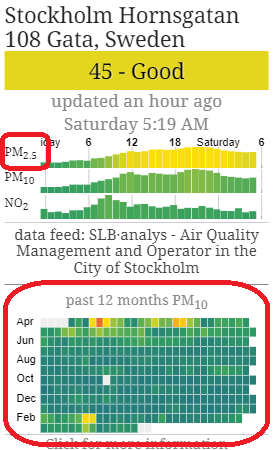

---

## <span style='color:#ff5f27'> 🌍 STEP 2: Download the Historical Air Quality </span>

You can download a CSV file containing the historical air quality data from your your sensor's URL.
Scroll down to the section "Air Quality Historical Data". Click on the PM2.5 option and save the file to the `data` directory in your forked version of this Github repository. Note the name of your CSV file, you will need 


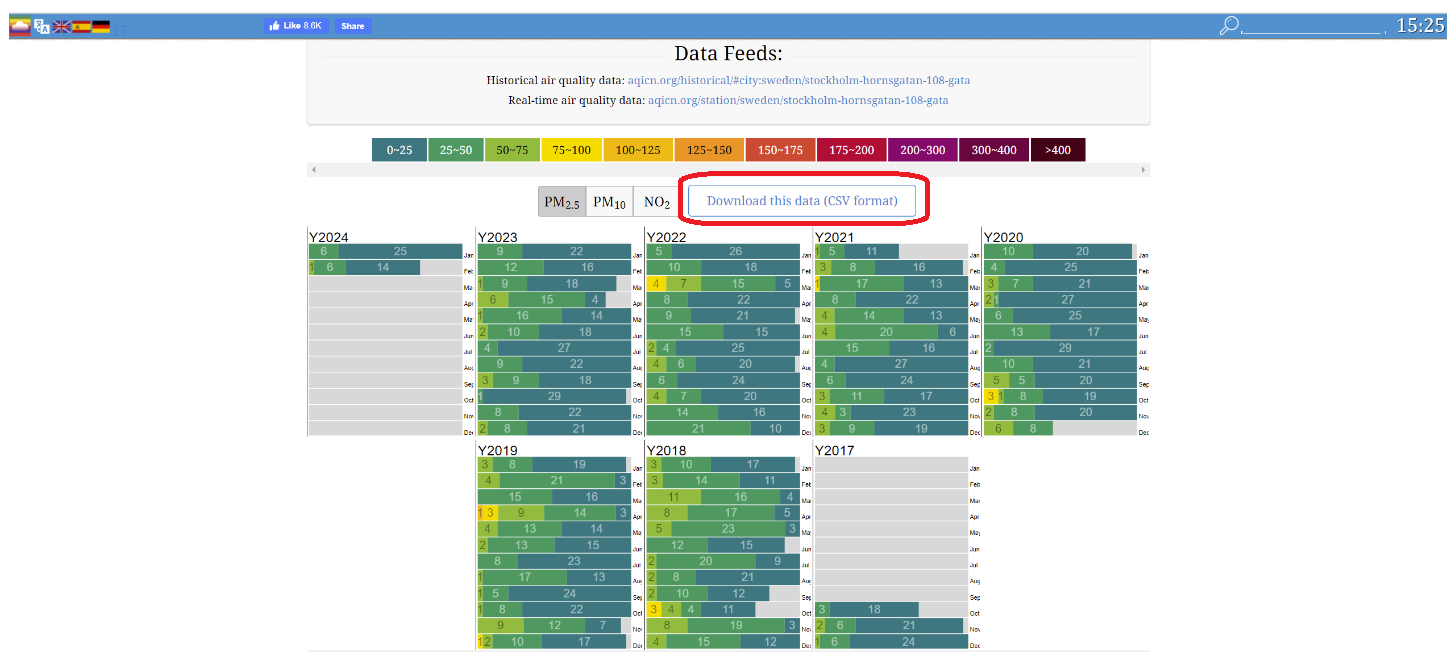

## <span style='color:#ff5f27'> 🌍 STEP 3: Get an AQICN API Token and Store it in .env file</span>

You have to first get your AQI API key [from here](https://aqicn.org/data-platform/token/):

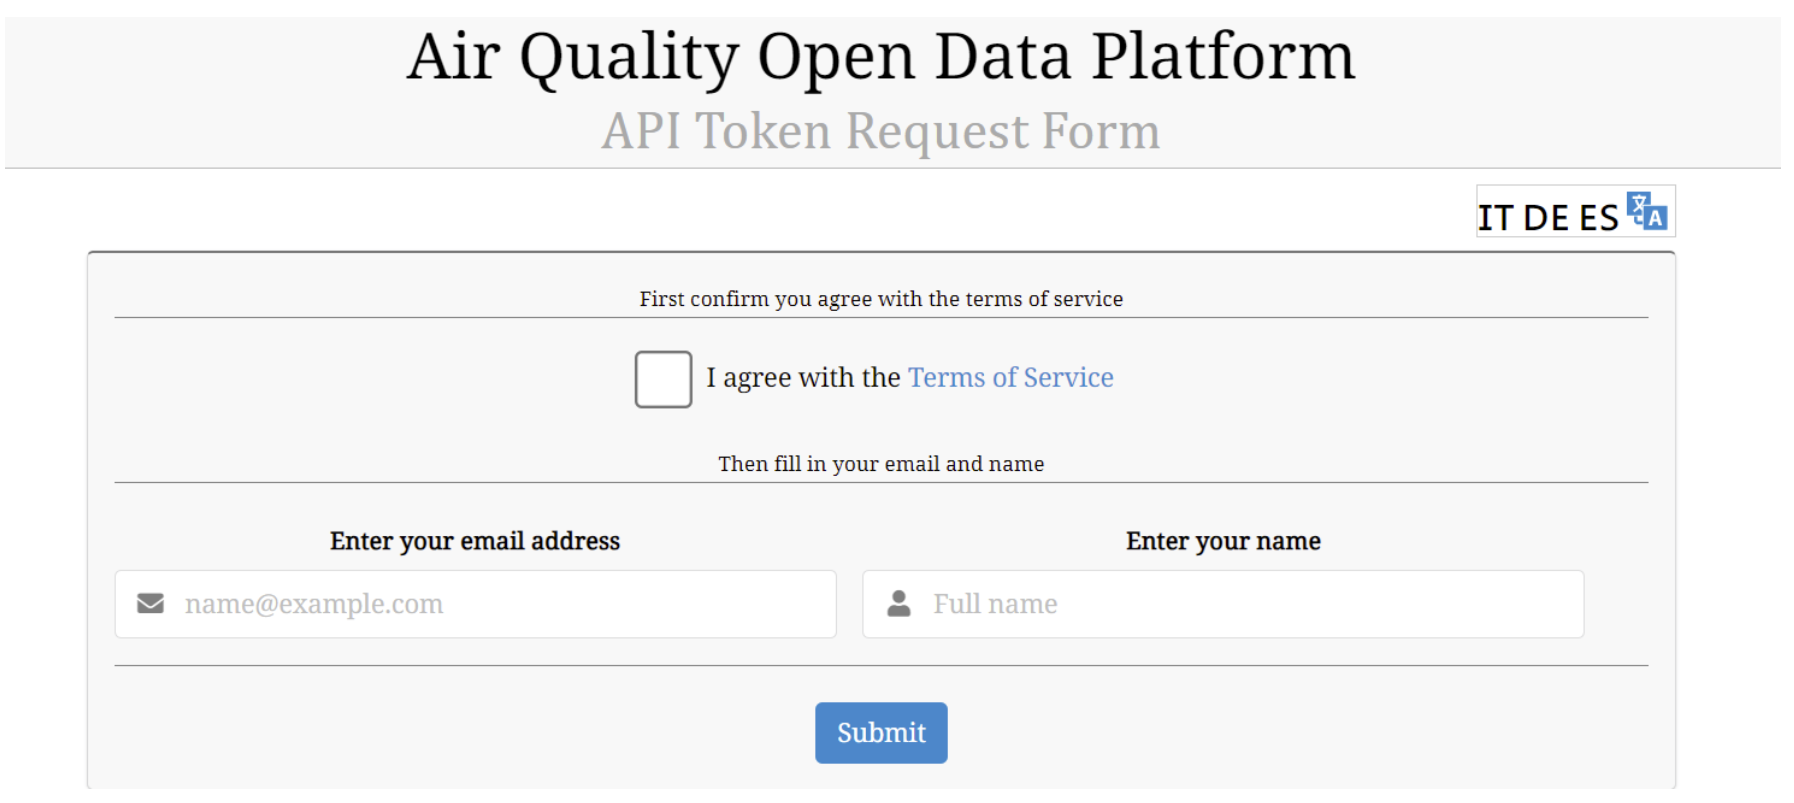


Save the API KEY to ~/.env file in the root directory of your project

 * mv .env.example .env
 * edit .env

In the .env file, update AQICN_API_KEY:

`AQICN_API_KEY="put API KEY value in this string"`


## <span style='color:#ff5f27'> 🔑 STEP 2: Connect to Hopsworks</span>

Make sure you have:
- Created an account on www.hopsworks.ai
- Set HOPSWORKS_API_KEY in `~/.env`
- Set AQICN_API_KEY in `~/.env`


In [5]:
# Get API keys from settings
if settings.AQICN_API_KEY is None:
    print("❌ You need to set AQICN_API_KEY in ~/.env")
    sys.exit(1)

AQICN_API_KEY = settings.AQICN_API_KEY.get_secret_value()
today = datetime.date.today()

# Open-Meteo historical API only allows data up to yesterday
yesterday = today - datetime.timedelta(days=1)

print(f"✅ Found AQICN_API_KEY")
print(f"📅 Today's date: {today}")
print(f"📅 Weather data end date: {yesterday} (Open-Meteo limitation)")

# Login to Hopsworks
print("\n🔐 Logging in to Hopsworks...")
project = hopsworks.login()
fs = project.get_feature_store()
secrets = hopsworks.get_secrets_api()

print("✅ Successfully connected to Hopsworks!")


✅ Found AQICN_API_KEY
📅 Today's date: 2025-11-14
📅 Weather data end date: 2025-11-13 (Open-Meteo limitation)

🔐 Logging in to Hopsworks...
2025-11-14 06:17:08,292 INFO: Initializing external client
2025-11-14 06:17:08,292 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-14 06:17:09,826 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1298582
✅ Successfully connected to Hopsworks!


In [6]:
# Save API key and sensor configuration to Hopsworks Secrets
print("\n💾 Saving configuration to Hopsworks Secrets...")

# Save AQICN_API_KEY
secret = secrets.get_secret("AQICN_API_KEY")
if secret is not None:
    secret.delete()
    print("  Replacing existing AQICN_API_KEY")
secrets.create_secret("AQICN_API_KEY", AQICN_API_KEY)

# Save Vienna sensors configuration as JSON string
vienna_config_str = json.dumps(vienna_config)
secret = secrets.get_secret("VIENNA_SENSORS_CONFIG")
if secret is not None:
    secret.delete()
    print("  Replacing existing VIENNA_SENSORS_CONFIG")
secrets.create_secret("VIENNA_SENSORS_CONFIG", vienna_config_str)

print("✅ Configuration saved to Hopsworks Secrets!")



💾 Saving configuration to Hopsworks Secrets...
  Replacing existing AQICN_API_KEY
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets
  Replacing existing VIENNA_SENSORS_CONFIG
Secret created successfully, explore it at https://c.app.hopsworks.ai:443/account/secrets
✅ Configuration saved to Hopsworks Secrets!


## <span style='color:#ff5f27'> 📂 STEP 3: Load Historical PM2.5 Data from CSV Files</span>

We will read CSV files for all **9 active sensors** and combine them into a single DataFrame.

Each CSV file contains:
- `date`: Measurement date
- `pm25`: PM2.5 value


In [7]:
# Load CSV files for all active sensors
all_sensor_data = []

print("📊 Loading CSV files for active sensors...\n")

for i, sensor in enumerate(active_sensors, 1):
    csv_file = f"{data_dir}/{sensor['csv_file']}"
    
    try:
        # Read CSV file
        df_sensor = pd.read_csv(csv_file, parse_dates=['date'], skipinitialspace=True)
        
        # Select only date and pm25 columns
        df_sensor = df_sensor[['date', 'pm25']]
        
        # Convert pm25 to float32
        df_sensor['pm25'] = df_sensor['pm25'].astype('float32')
        
        # Drop rows with missing pm25 values
        initial_rows = len(df_sensor)
        df_sensor.dropna(subset=['pm25'], inplace=True)
        dropped_rows = initial_rows - len(df_sensor)
        
        # Add sensor metadata
        df_sensor['country'] = country
        df_sensor['city'] = city
        df_sensor['street'] = sensor['street']
        df_sensor['url'] = sensor['aqicn_url']
        
        all_sensor_data.append(df_sensor)
        
        print(f"  ✅ {i}. {sensor['name']}")
        print(f"      File: {sensor['csv_file']}")
        print(f"      Rows: {len(df_sensor)} (dropped {dropped_rows} with missing PM2.5)")
        print(f"      Date range: {df_sensor['date'].min()} to {df_sensor['date'].max()}")
        print()
        
    except FileNotFoundError:
        print(f"  ❌ {i}. {sensor['name']} - File not found: {csv_file}")
        print()
    except Exception as e:
        print(f"  ❌ {i}. {sensor['name']} - Error: {str(e)}")
        print()

print(f"\n📊 Successfully loaded {len(all_sensor_data)} sensor datasets")


📊 Loading CSV files for active sensors...

  ✅ 1. Kendlerstraße 40 (Umspannwerk)
      File: vienna_kendlerstrasse.csv
      Rows: 4287 (dropped 28 with missing PM2.5)
      Date range: 2014-01-01 00:00:00 to 2025-11-13 00:00:00

  ✅ 2. Hausgrundweg 23, Gstr. 254
      File: vienna_hausgrundweg.csv
      Rows: 4287 (dropped 28 with missing PM2.5)
      Date range: 2014-01-01 00:00:00 to 2025-11-13 00:00:00

  ✅ 3. Allgemeines Krankenhaus, Ostringweg
      File: vienna_akh_ostringweg.csv
      Rows: 994 (dropped 11 with missing PM2.5)
      Date range: 2023-02-05 00:00:00 to 2025-11-13 00:00:00

  ✅ 4. Umspannwerk Gaudenzdorfer Gürtel
      File: vienna_gaudenzdorfer.csv
      Rows: 1863 (dropped 1410 with missing PM2.5)
      Date range: 2020-09-14 00:00:00 to 2025-11-13 00:00:00

  ✅ 5. Belgradplatz (Südostecke), Gstr.Nr. 816
      File: vienna_belgradplatz.csv
      Rows: 2476 (dropped 1837 with missing PM2.5)
      Date range: 2019-01-03 00:00:00 to 2025-11-13 00:00:00

  ✅ 6. Flori

In [8]:
# Combine all sensor data into one DataFrame
if len(all_sensor_data) > 0:
    df_aq = pd.concat(all_sensor_data, ignore_index=True)
    
    print(f"\n✅ Combined Air Quality DataFrame:")
    print(f"   Total rows: {len(df_aq)}")
    print(f"   Sensors: {df_aq['street'].nunique()}")
    print(f"   Date range: {df_aq['date'].min()} to {df_aq['date'].max()}")
    print(f"\n📊 DataFrame Info:")
    df_aq.info()
    
    print(f"\n🔍 Sample data:")
    display(df_aq.head(10))
else:
    print("❌ No sensor data loaded! Please check your CSV files.")
    sys.exit(1)



✅ Combined Air Quality DataFrame:
   Total rows: 27686
   Sensors: 9
   Date range: 2014-01-01 00:00:00 to 2025-11-13 00:00:00

📊 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     27686 non-null  datetime64[ns]
 1   pm25     27686 non-null  float32       
 2   country  27686 non-null  object        
 3   city     27686 non-null  object        
 4   street   27686 non-null  object        
 5   url      27686 non-null  object        
dtypes: datetime64[ns](1), float32(1), object(4)
memory usage: 1.2+ MB

🔍 Sample data:


,date,pm25,country,city,street,url
0,2025-11-02,47.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
1,2025-11-03,9.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
2,2025-11-04,33.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
3,2025-11-05,40.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
4,2025-11-06,50.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
5,2025-11-07,39.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
6,2025-11-08,56.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
7,2025-11-09,37.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
8,2025-11-10,40.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850
9,2025-11-11,34.0,Austria,Vienna,Kendlerstrasse-40,https://api.waqi.info/feed/@2850


---

## <span style='color:#ff5f27'> 🌦 STEP 4: Load Weather Data for Vienna</span>

We will download historical weather data from [Open-Meteo](https://open-meteo.com/en/docs/historical-weather-api) for Vienna.

Weather features include:
- `temperature_2m_mean`: Average daily temperature
- `precipitation_sum`: Total daily precipitation
- `wind_speed_10m_max`: Maximum daily wind speed
- `wind_direction_10m_dominant`: Dominant daily wind direction


In [9]:
# Get the earliest date from air quality data
earliest_aq_date = pd.Series.min(df_aq['date'])
earliest_aq_date_str = earliest_aq_date.strftime('%Y-%m-%d')

print(f"📅 Earliest air quality measurement: {earliest_aq_date_str}")
print(f"📅 Weather data end date: {yesterday} (Open-Meteo limitation)")

# Fetch weather data for EACH sensor location (not just city center)
print(f"\n🌍 Fetching weather data for each sensor location...")
print(f"   This ensures accurate weather data for each specific area")
print(f"   ⏰ Estimated time: ~{(len(active_sensors)-1) * 10 / 60:.1f} minutes\n")

all_weather_data = []

for i, sensor in enumerate(active_sensors, 1):
    sensor_lat = sensor['latitude']
    sensor_lon = sensor['longitude']
    sensor_street = sensor['street']
    
    print(f"  {i}/{len(active_sensors)}. {sensor['name']}")
    print(f"      Coordinates: ({sensor_lat:.4f}, {sensor_lon:.4f})")
    
    try:
        # Download weather data for this specific sensor location
        weather_df_sensor = util.get_historical_weather(
            city, 
            earliest_aq_date_str, 
            str(yesterday), 
            sensor_lat, 
            sensor_lon
        )
        
        # Add sensor identifier to weather data
        weather_df_sensor['street'] = sensor_street
        
        all_weather_data.append(weather_df_sensor)
        print(f"      ✅ {len(weather_df_sensor)} weather records downloaded")
            
    except Exception as e:
        print(f"      ❌ Error: {str(e)}")
        print(f"      Skipping this sensor...\n")
        continue

# Combine weather data from all locations
if len(all_weather_data) > 0:
    weather_df = pd.concat(all_weather_data, ignore_index=True)
    
    print(f"\n✅ Weather data downloaded for {len(all_weather_data)} sensor locations!")
    print(f"   Total rows: {len(weather_df)}")
    print(f"   Unique locations: {weather_df['street'].nunique()}")
    print(f"   Date range: {weather_df['date'].min()} to {weather_df['date'].max()}")
    print(f"\n📊 Weather DataFrame Info:")
    weather_df.info()
else:
    print("\n❌ No weather data downloaded! Please check the errors above.")
    sys.exit(1)


📅 Earliest air quality measurement: 2014-01-01
📅 Weather data end date: 2025-11-13 (Open-Meteo limitation)

🌍 Fetching weather data for each sensor location...
   This ensures accurate weather data for each specific area
   ⏰ Estimated time: ~1.3 minutes

  1/9. Kendlerstraße 40 (Umspannwerk)
      Coordinates: (48.2050, 16.3098)
Coordinates 48.18980407714844°N 16.377296447753906°E
Elevation 234.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
      ✅ 4335 weather records downloaded
  2/9. Hausgrundweg 23, Gstr. 254
      Coordinates: (48.2264, 16.4583)
Coordinates 48.26010513305664°N 16.404682159423828°E
Elevation 160.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
      ✅ 4335 weather records downloaded
  3/9. Allgemeines Krankenhaus, Ostringweg
      Coordinates: (48.2191, 16.3498)
Coordinates 48.18980407714844°N 16.377296447753906°E
Elevation 199.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
      ✅ 4335 weather records downloaded
  4/9. Umspann

---

## <span style='color:#ff5f27'> ✅ STEP 5: Define Data Validation Rules</span>

We use Great Expectations to validate data before inserting into Feature Store.


In [10]:
import great_expectations as ge

# Air Quality expectations
aq_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="aq_expectation_suite"
)

aq_expectation_suite.add_expectation(
    ge.core.ExpectationConfiguration(
        expectation_type="expect_column_min_to_be_between",
        kwargs={
            "column": "pm25",
            "min_value": -0.1,
            "max_value": 500.0,
            "strict_min": True
        }
    )
)

print("✅ Air Quality validation rules defined")

# Weather expectations
weather_expectation_suite = ge.core.ExpectationSuite(
    expectation_suite_name="weather_expectation_suite"
)

def expect_greater_than_zero(col):
    weather_expectation_suite.add_expectation(
        ge.core.ExpectationConfiguration(
            expectation_type="expect_column_min_to_be_between",
            kwargs={
                "column": col,
                "min_value": -0.1,
                "max_value": 1000.0,
                "strict_min": True
            }
        )
    )

expect_greater_than_zero("precipitation_sum")
expect_greater_than_zero("wind_speed_10m_max")

print("✅ Weather validation rules defined")


✅ Air Quality validation rules defined
✅ Weather validation rules defined


---

## <span style='color:#ff5f27'> 🗄️ STEP 6: Create Feature Groups and Insert Data</span>

We will create/update two Feature Groups:
1. **air_quality_vienna**: PM2.5 measurements from all Vienna sensors
2. **weather_vienna**: Weather data for each Vienna sensor location


In [11]:
# Create or get Air Quality Feature Group
print("🔄 Creating/updating Air Quality Feature Group...")

air_quality_fg = fs.get_or_create_feature_group(
    name='air_quality_vienna',
    description='Air Quality (PM2.5) measurements from multiple sensors in Vienna',
    version=1,
    primary_key=['country', 'city', 'street'],
    event_time="date",
    expectation_suite=aq_expectation_suite
)

print(f"✅ Feature Group '{air_quality_fg.name}' ready")
print(f"   Version: {air_quality_fg.version}")
print(f"   Primary key: {air_quality_fg.primary_key}")

# Insert air quality data
print(f"\n📤 Inserting {len(df_aq)} rows of air quality data...")
print(f"   From {df_aq['street'].nunique()} sensors")

air_quality_fg.insert(df_aq)

print("✅ Air quality data inserted successfully!")


🔄 Creating/updating Air Quality Feature Group...
✅ Feature Group 'air_quality_vienna' ready
   Version: 1
   Primary key: ['country', 'city', 'street']

📤 Inserting 27686 rows of air quality data...
   From 9 sensors
2025-11-14 06:17:12,911 INFO: 	1 expectation(s) included in expectation_suite.
Validation succeeded.
Validation Report saved successfully, explore a summary at https://c.app.hopsworks.ai:443/p/1298582/fs/1286214/fg/1703402


Uploading Dataframe: 100.00% |████████████████████████████████████████████████████████████| Rows 27686/27686 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_vienna_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_vienna_1_offline_fg_materialization/executions
✅ Air quality data inserted successfully!


In [ ]:
# Create or get Weather Feature Group
print("\n🔄 Creating/updating Weather Feature Group...")

weather_fg = fs.get_or_create_feature_group(
    name='weather_vienna',
    description='Daily weather data for each sensor location in Vienna from Open-Meteo',
    version=1,
    primary_key=['city', 'street'],  # ← Changed: now includes 'street' to distinguish locations
    event_time="date",
    expectation_suite=weather_expectation_suite
)

print(f"✅ Feature Group '{weather_fg.name}' ready")
print(f"   Version: {weather_fg.version}")
print(f"   Primary key: {weather_fg.primary_key}")
print(f"   📍 Weather data is location-specific (per sensor)")

# Insert weather data
print(f"\n📤 Inserting {len(weather_df)} rows of weather data...")
print(f"   From {weather_df['street'].nunique()} sensor locations")

weather_fg.insert(weather_df, wait=True)

print("✅ Weather data inserted successfully!")


---

## <span style='color:#ff5f27'> 🎉 Feature Backfill Complete!</span>

Successfully completed the following:
- ✅ Loaded configuration for 9 active Vienna sensors
- ✅ Processed historical PM2.5 data from CSV files
- ✅ Downloaded **location-specific** weather data for each sensor (not just city center!)
- ✅ Created/updated Feature Groups in Hopsworks
- ✅ Inserted all historical data into Feature Store

### 🎯 Key Improvement:
Weather data is **location-specific** for each sensor. This ensures:
- More accurate predictions (weather varies across the city)
- Better model performance (temperature/wind/precipitation differences matter)
- Proper join with air quality data (by city + street)

### Next Steps:
1. Run `2_air_quality_feature_pipeline.ipynb` for daily data updates
2. Run `3_air_quality_training_pipeline.ipynb` to train models
3. Run `4_air_quality_batch_inference.ipynb` for predictions


In [ ]:
# Print summary statistics
print("="*80)
print("📊 BACKFILL SUMMARY")
print("="*80)
print(f"\n🌍 Location: {city}, {country}")
print(f"\n📡 Sensors processed: {len(active_sensors)}")
for i, sensor in enumerate(active_sensors, 1):
    print(f"   {i}. {sensor['name']} ({sensor['street']})")

print(f"\n📊 Data Statistics:")
print(f"   Air Quality records: {len(df_aq):,}")
print(f"   Weather records: {len(weather_df):,}")
print(f"   Date range: {df_aq['date'].min().date()} to {df_aq['date'].max().date()}")
print(f"   Days covered: {(df_aq['date'].max() - df_aq['date'].min()).days}")

print(f"\n✅ Feature Groups:")
print(f"   1. air_quality (v{air_quality_fg.version})")
print(f"   2. weather (v{weather_fg.version})")

print(f"\n🔗 Hopsworks Project: {project.name}")
print("="*80)


---

## <span style="color:#ff5f27;">⏭️ **Next:** Part 02: Daily Feature Pipeline 
 </span> 


## <span style="color:#ff5f27;">⏭️ **Exercises:** 
 </span> 

Extra Homework:

  * Try adding a new feature based on a rolling window of 3 days for 'pm25'
      * This is not easy, as forecasting more than 1 day in the future, you won't have the previous 3 days of pm25 measurements.
      * df.set_index("date").rolling(3).mean() is only the start....
  * Parameterize the notebook, so that you can provide the `country`/`street`/`city`/`url`/`csv_file` as parameters. 
      * Hint: this will also require making the secret name (`SENSOR_LOCATION_JSON`), e.g., add the street name as part of the secret name. Then you have to pass that secret name as a parameter when running the operational feature pipeline and batch inference pipelines.
      * After you have done this, collect the street/city/url/csv files for all the sensors in your city or region and you make dashboards for all of the air quality sensors in your city/region. You could even then add a dashboard for your city/region, as done [here for Poland](https://github.com/erno98/ID2223).

Improve this AI System
  * As of mid 2024, there is no API call available to download historical data from the AQIN website. You could improve this system by writing a PR to download the CSV file using Python Selenium and the URL for the sensor.


---